This code sets up and prepares the *CIFAKE* dataset for training and testing a machine learning model. The user first uploads their own Kaggle API key (kaggle.json), installs the Kaggle Python package, and configures authentication settings to access Kaggle datasets. Using the authenticated API, it downloads and unzips the "CIFAKE: Real and AI-Generated Synthetic Images" dataset into the environment. After ensuring the correct dataset directory is set, the code uses TensorFlow’s *image_dataset_from_directory* function to load the training and testing images into TensorFlow datasets, automatically resizing all images to 128×128 pixels and organizing them into batches of 500. Finally, it prints the available class labels for the user to verify that the datasets have been loaded correctly and are ready to be used for model training and evaluation.

In [1]:
# THIS IS IMPORTANT IN ORDER TO RUN SOME OF THE CODE CELLS BELOW
# 1. Access this link: https://drive.google.com/drive/folders/1Glkvd8CqQwPk38LJiVh6cUG4-8RrL-h2?usp=sharing. This is the link for our shared Google Drive
# 2. Click on the title of the drive: Intro ML Final Project -> Organize -> Add Shortcut -> My Drive (this is really important)
# 3. Once the shortcut is added to "My Drive", refresh the notebook and run this cell again. You should be able to see the folder contents.

from google.colab import drive
import os

drive.mount('/content/drive')

FOLDER = '/content/drive/My Drive/Intro ML Final Project'

os.chdir(FOLDER)

print("Working directory:", os.getcwd())
print("Folder contents:", os.listdir('.'))


Mounted at /content/drive
Working directory: /content/drive/My Drive/Intro ML Final Project
Folder contents: ['cifake-real-and-ai-generated-synthetic-images.zip', 'Intro ML Project Proposal: Tim, Austin, Mikail, David.gdoc', 'final_project_spring_2025.pdf', '__pycache__', 'eval_output', 'GENERAL PLAN.gdoc', 'Copy of AI_Image_Detection_CNN.ipynb', 'cnn_1', 'skip_vae_stage1.pth', 'skip_vae_two_stage.pth', 'skip_vae_two_stage_final.pth', 'Write-up Final.gdoc', 'AI_Image_Detection_CNN.ipynb']


In [2]:
# NOTE: YOU MUST DO THIS ON GOOGLE COLAB IN ORDER TO ACCESS OUR DATASET
# 1. Create an account on kaggle.com
# 2. Go to settings -> API -> Create new token -> Download token
# 3. You should've downloaded a file called kaggle.json which this cell will then add you to upload

from google.colab import files
files.upload()  # HERE we want to select kaggle.json

!pip install --quiet kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

from kaggle.api.kaggle_api_extended import KaggleApi
import os

api = KaggleApi()
api.authenticate()

slug = 'birdy654/cifake-real-and-ai-generated-synthetic-images'


api.dataset_download_files(slug, path='/content', unzip=True, quiet=False)

# The folder disappears after we unzip it sometimes so we check if the folder is still there or not
root = '/content'
contents = os.listdir(root)
if 'train' in contents and 'test' in contents:
    dataset_dir = root
else:
    folder = slug.split('/')[-1]
    dataset_dir = os.path.join(root, folder)

print('Using dataset directory:', dataset_dir)
print('Subfolders:', os.listdir(dataset_dir))

# We want to access our images as tensor flow datasets, if we try to access them one image at a time as a .png file, the dataset will be too big to use

import tensorflow as tf
img_height = 128
img_width  = 128
batch_size = 500


with tf.device('/CPU:0'):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        seed=512,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_dir, 'test'),
        seed=512,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

print('Training classes:', train_ds.class_names)
print('Testing  classes:', test_ds.class_names)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
Using dataset directory: /content
Subfolders: ['.config', 'drive', 'train', 'test', 'sample_data']
Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training classes: ['FAKE', 'REAL']
Testing  classes: ['FAKE', 'REAL']


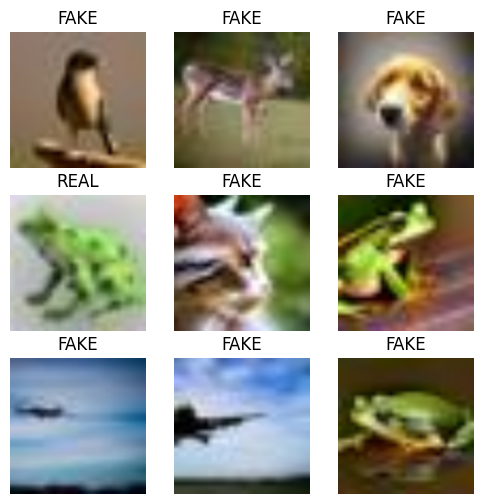

In [3]:
# We want to confirm that we were able to download the images correctly.

import matplotlib.pyplot as plt
import numpy as np

# We want to show 9 images
num_images = 9

for images, labels in train_ds.take(1):
    batch_images = images.numpy().astype("uint8")
    batch_labels = labels.numpy()
    break

class_names = train_ds.class_names

# Plot the images
plt.figure(figsize=(6, 6))
for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(batch_images[i])
    plt.title(class_names[batch_labels[i]])
    plt.axis("off")

plt.show()


In [ ]:
# This is our first CNN that we implemented. It is a classic CNN that uses the VGGNet-11 encoder and also incorporates a learning rate decay.
# This CNN takes an extremely long time to run especially when compared to the other ones.
#
# (For my group, DO NOT run this cell again as we don't want to waste time)

!python cnn_1/train_classification_cnn.py \
    --dataset custom \
    --data_dir /content/ \
    --n_batch 64 \
    --encoder_type 'vggnet11' \
    --n_epoch 20 \
    --learning_rate 0.1 \
    --learning_rate_decay 0.95 \
    --learning_rate_period 5 \
    --checkpoint_path /content/checkpoints \
    --device 'cuda'


In [ ]:
!python cnn_1/run_classification_cnn.py \
    --data_dir /content/ \
    --checkpoint /content/checkpoints/model-19.pth \
    --output /output/ \
    --encoder_type 'vggnet11' \
    --n_batch 64 \
    --device 'cuda'


In [ ]:
# This is our second CNN that we implemented.

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(128, 128, 3)),
    tf.keras.layers.Rescaling(scale=1./255),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(),

    loss='binary_crossentropy',

    metrics=['accuracy', tf.keras.metrics.AUC(name='roc_auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
        tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("--Train start--")

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=10,
  verbose=1
)
print("--Train end--")


--Train start--
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 58s 220ms/step - accuracy: 0.5026 - loss: 1.2583 - pr_auc: 0.5082 - precision: 0.5085 - recall: 0.1928 - roc_auc: 0.5040 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_pr_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 225ms/step - accuracy: 0.4990 - loss: 0.6932 - pr_auc: 0.5010 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_pr_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 65s 141ms/step - accuracy: 0.4988 - loss: 0.6932 - pr_auc: 0.5012 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_pr_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 161ms/step - accuracy: 0.49

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)[:, 0]
    preds = (probs >= 0.5).astype(int)

    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
classes = train_ds.class_names

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

# This is our third CNN that we implemented that takes advantage of a pretrained CNN on ImageNet which is a collection of common images

import tensorflow as tf

base = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

base.trainable = False

inputs  = tf.keras.Input(shape=(128, 128, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)

x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit(train_ds, validation_data=test_ds, epochs=5, verbose=1)

for layer in base.layers[int(len(base.layers) * 0.67):]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='roc_auc'),
    tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
    tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history_ft = model.fit(train_ds, validation_data=test_ds, initial_epoch=history.epoch[-1] + 1, epochs=15, verbose=1)




In [ ]:
y_true, y_pred = [], []
for batch_imgs, batch_labels in test_ds:
    probs = model.predict(batch_imgs, verbose=0)[:, 0]
    preds = (probs >= 0.5).astype(int)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
labels = train_ds.class_names

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix — Transfer‑Learning Model')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L

weight_decay = 0.0001

inputs = L.Input(shape=(128, 128, 3))
x = L.Rescaling(1./255)(inputs)

for filters in [32, 64, 128]:
    x = L.Conv2D(filters, 3, padding='same',
                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    x = L.SpatialDropout2D(0.2)(x)
    x = L.MaxPooling2D()(x)

x = L.GlobalAveragePooling2D()(x)
x = L.Dropout(0.35)(x)
outputs = L.Dense(1, activation='sigmoid')(x)

model_reg = tf.keras.Model(inputs, outputs)

opt = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=weight_decay)

model_reg.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tf.keras.metrics.AUC(name='roc_auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
        tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history_reg = model_reg.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    batch_size=32,
    callbacks=[early],
    verbose=1
)


In [ ]:
y_true, y_pred = [], []
for batch_imgs, batch_labels in test_ds:
    probs = model_reg.predict(batch_imgs, verbose=0)[:, 0]
    preds = (probs >= 0.5).astype(int)

    y_true.extend(batch_labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
labels = train_ds.class_names

plt.figure(figsize=(5,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix — Regularized CNN')
plt.show()

In [ ]:
# Plots statistics about the CNNs such as loss, accuracy, AUC, etc.

import matplotlib.pyplot as plt

def plot_training_history(history):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    all_metrics = [
        ('loss', 'Loss'),
        ('accuracy', 'Accuracy'),
        ('roc_auc', 'ROC AUC'),
        ('pr_auc', 'PR AUC'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
    ]

    metrics = [(key, name) for key, name in all_metrics if key in hist]

    n = len(metrics)
    if n == 0:
        print("No plottable metrics found in history.")
        return


    fig, axes = plt.subplots(1, n, figsize=(4 * n, 3), squeeze=False)

    for i, (key, title) in enumerate(metrics):
        ax = axes[0, i]
        ax.plot(epochs, hist[key],    linestyle='-', label=f'Train {title}')
        val_key = f'val_{key}'
        if val_key in hist:
            ax.plot(epochs, hist[val_key], linestyle='--', label=f'Val {title}')
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend(loc='best', fontsize='small')

    fig.tight_layout()
    plt.show()


In [ ]:
# Plotting some statistics

plot_training_history(history)
plot_training_history(history_ft)
plot_training_history(history_reg)

The code below is to implement our VAEs

In [ ]:
# Don't know if you need to install this for this VAE but we had to install this
# at some point so if something doesn't work you can install this
!pip install lpips


In [ ]:
# First we want to implement some architectural blocks

import torch
import torch.nn as nn
import torch.nn.functional as F
import lpips
import tensorflow as tf

class ConvBlock(nn.Module):
    def __init__(self, in_c: int, out_c: int, down: bool = True):
        super().__init__()
        stride = 2 if down else 1
        self.seq = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.seq(x)

class UpBlock(nn.Module):
    def __init__(self, in_c: int, out_c: int):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.seq(x)

class SkipConvVAE(nn.Module):
    def __init__(self, img_size: int = 128, latent_dim: int = 256):
        super().__init__()
        self.img_size = img_size
        assert img_size % 16 == 0
        f = img_size // 16

        # encoder
        self.enc1 = ConvBlock(3,  32, down=True)
        self.enc2 = ConvBlock(32, 64, down=True)
        self.enc3 = ConvBlock(64,128, down=True)
        self.enc4 = ConvBlock(128,256, down=True)
        self.enc5 = ConvBlock(256,512, down=False)

        flat_dim = 512 * f * f
        self.fc_mu  = nn.Linear(flat_dim, latent_dim)
        self.fc_log = nn.Linear(flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, flat_dim)

        # decoder
        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1,bias=False), nn.BatchNorm2d(256), nn.ReLU(True)
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(512,128,4,2,1,bias=False), nn.BatchNorm2d(128), nn.ReLU(True)
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(256, 64,4,2,1,bias=False), nn.BatchNorm2d(64),  nn.ReLU(True)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 32,4,2,1,bias=False), nn.BatchNorm2d(32),  nn.ReLU(True)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(64,32,3,1,1,bias=False), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 3,3,1,1), nn.Sigmoid()
        )

        # pure-latent decoder
        self.gen5 = UpBlock(512,256)
        self.gen4 = UpBlock(256,128)
        self.gen3 = UpBlock(128,64)
        self.gen2 = UpBlock(64,32)
        self.gen_head = nn.Sequential(
            nn.Conv2d(32,32,3,1,1,bias=False), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32,16,3,1,1), nn.ReLU(True),
            nn.Conv2d(16, 3,3,1,1), nn.Sigmoid()
        )

    def encode(self, x: torch.Tensor):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        h  = e5.reshape(e5.size(0), -1)
        return self.fc_mu(h), self.fc_log(h), (e1,e2,e3,e4,e5)

    def reparam(self, mu: torch.Tensor, logv: torch.Tensor):
        std = torch.exp(0.5*logv)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor, skips):
        e1,e2,e3,e4,e5 = skips
        bsz,f,_ = z.size(0), self.img_size//16, None
        h = self.fc_dec(z).reshape(bsz,512,f,f)

        d5 = self.dec5(h)
        e4u = F.interpolate(e4, size=d5.shape[2:], mode='nearest')
        d4i= torch.cat([d5,e4u],1)

        d4 = self.dec4(d4i)
        e3u= F.interpolate(e3,size=d4.shape[2:], mode='nearest')
        d3i=torch.cat([d4,e3u],1)

        d3 = self.dec3(d3i)
        e2u= F.interpolate(e2,size=d3.shape[2:], mode='nearest')
        d2i=torch.cat([d3,e2u],1)

        d2 = self.dec2(d2i)
        e1u= F.interpolate(e1,size=d2.shape[2:], mode='nearest')
        d1i=torch.cat([d2,e1u],1)

        return self.dec1(d1i)

    def sample(self, z: torch.Tensor):
        B = z.size(0)
        f = self.img_size//16
        h = self.fc_dec(z).reshape(B,512,f,f)
        x = self.gen5(h)
        x = self.gen4(x)
        x = self.gen3(x)
        x = self.gen2(x)
        return self.gen_head(x)

    def forward(self, x: torch.Tensor):
        mu,logv,sk = self.encode(x)
        logv = torch.clamp(logv,-10,10)
        z    = self.reparam(mu, logv)
        return self.decode(z,sk), mu, logv

    @torch.no_grad()
    def anomaly_score(self, x: torch.Tensor):
        xh, _, _ = self.forward(x)
        err = F.mse_loss(xh, x, reduction='none')
        return err.view(x.size(0), -1).mean(1)

class TrainCfg:
    def __init__(self,
                 epochs: int = 40,
                 beta_start: float = 0.0,
                 beta_end: float   = 1.0,
                 lr: float         = 1e-4,
                 batch: int        = 16,
                 device: str       = None):
        self.epochs     = epochs
        self.beta_start = beta_start
        self.beta_end   = beta_end
        self.lr         = lr
        self.batch      = batch
        self.device     = device or ('cuda' if torch.cuda.is_available() else 'cpu')

percep_loss = lpips.LPIPS(net='alex')

def tf_to_torch(batch_x: tf.Tensor, device: str):
    arr = batch_x.numpy()
    return torch.from_numpy(arr).permute(0,3,1,2).float().div(255.).to(device)



In [ ]:
# This is our training function

def train_vae_stream(real_ds,
                     img_size: int = 128,
                     cfg: TrainCfg      = None,
                     stage1_epochs: int = 20  # how many epochs for Stage 1
                    ) -> SkipConvVAE:
    cfg    = cfg or TrainCfg()
    device = cfg.device
    percep = percep_loss.to(device)

    vae   = SkipConvVAE(img_size=img_size, latent_dim=256).to(device)
    opt   = torch.optim.AdamW(vae.parameters(), lr=cfg.lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=cfg.epochs)

    batch_size = cfg.batch
    autotune    = tf.data.AUTOTUNE


    ds = real_ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=autotune)



    print(f"\n[Stage 1] training skip‑VAE for {stage1_epochs} epochs (α=0)")
    vae.train()
    for ep in range(stage1_epochs):
        running, seen = 0.0, 0
        beta = cfg.beta_start + (cfg.beta_end - cfg.beta_start) * min(1.0, ep/20)


        for xb_tf, _ in ds:
            xb = tf_to_torch(xb_tf, device)
            xh, mu, logv = vae(xb)
            bce   = F.binary_cross_entropy(xh, xb)
            mse   = F.mse_loss(xh, xb)
            lp    = percep(xh, xb).mean()
            recon = bce + 0.5*mse + 0.25*lp
            kl    = -0.5 * torch.mean(1 + logv - mu.pow(2) - logv.exp())
            loss  = recon + beta * kl

            opt.zero_grad()
            loss.backward()
            opt.step()

            running += loss.item()*xb.size(0)
            seen    += xb.size(0)

        sched.step()
        print(f" Stage 1 Epochs {ep+1}/{stage1_epochs}  β={beta:.2f}  loss={running/seen:.4f}")

    torch.save(vae.state_dict(), "skip_vae_stage1.pth")


    print(f"\n[Stage 2] freeze skip path, teach pure decoder for {cfg.epochs-stage1_epochs} epochs")

    for name, p in vae.named_parameters():
        if name.startswith("gen"):
            p.requires_grad = True
        else:
            p.requires_grad = False


    gen_params = [p for p in vae.parameters() if p.requires_grad]
    opt2 = torch.optim.AdamW(gen_params, lr=cfg.lr*0.5)
    sched2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, T_max=cfg.epochs - stage1_epochs)


    vae.train()
    for ep in range(stage1_epochs, cfg.epochs):
        running, seen = 0.0, 0
        for xb_tf, _ in ds:
            xb = tf_to_torch(xb_tf, device)

            with torch.no_grad():
                teacher, mu, logv = vae(xb)
            student = vae.sample(vae.reparam(mu, logv))

            mse_t = F.mse_loss(student, teacher)
            lp_t  = percep(student, teacher).mean()
            loss  = mse_t + 0.1 * lp_t

            opt2.zero_grad()
            loss.backward()
            opt2.step()

            running += loss.item()*xb.size(0)
            seen    += xb.size(0)

        sched2.step()
        print(f" Stage 2 Epochs {ep+1-stage1_epochs}/{cfg.epochs-stage1_epochs}  loss={running/seen:.4f}")

    torch.save(vae.state_dict(), "skip_vae_two_stage.pth")
    vae.eval()
    return vae


In [ ]:
import os

dataset_dir = os.getenv('DATASET_DIR', '/content')
img_h = img_w = 128

tf.random.set_seed(512)

with tf.device('/CPU:0'):
    ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(dataset_dir, 'train'),
        seed=512,
        image_size=(img_h, img_w),
        batch_size=1,
    )


real_ds = ds.unbatch().filter(lambda x, y: tf.equal(y, 0)).take(2000)


cfg = TrainCfg(
    epochs     = 40,
    beta_start = 0.0,
    beta_end   = 1.0,
    lr         = 1e-4,
    batch      = 16,
)

print("--Train start--")
vae = train_vae_stream(
    real_ds         = real_ds,
    img_size        = img_h,
    cfg             = cfg,
    stage1_epochs   = 20,
)
print("--Train end--")


out_path = 'skip_vae_two_stage_final.pth'
torch.save(vae.state_dict(), out_path)
print(f"Saved final checkpoint to {out_path}")


In [ ]:
import torch
import matplotlib.pyplot as plt
import tensorflow as tf


vae = SkipConvVAE(img_size=128, latent_dim=256)
vae.load_state_dict(torch.load('skip_vae_two_stage_final.pth', map_location='cpu'))
vae.eval()


real_iter = (
    test_ds
    .unbatch()
    .filter(lambda x,y: tf.equal(y, 0))
    .batch(4)
    .take(1)
)
fake_iter = (
    test_ds
    .unbatch()
    .filter(lambda x,y: tf.equal(y, 1))
    .batch(4)
    .take(1)
)
real_imgs, _ = next(iter(real_iter))
fake_imgs, _ = next(iter(fake_iter))


real_t = tf_to_torch(real_imgs, device='cpu')
fake_t = tf_to_torch(fake_imgs, device='cpu')


with torch.no_grad():
    # real
    mu_r, logv_r, skips_r = vae.encode(real_t)
    z_r = vae.reparam(mu_r, logv_r)
    real_recon = vae.decode(z_r, skips_r)
    # fake
    mu_f, logv_f, skips_f = vae.encode(fake_t)
    z_f = vae.reparam(mu_f, logv_f)
    fake_recon = vae.decode(z_f, skips_f)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i in range(4):

    axes[0,i].imshow(real_imgs[i].numpy().astype('uint8'))
    axes[0,i].set_title("Real In")
    axes[0,i].axis('off')

    recon_r = real_recon[i].permute(1,2,0).cpu().numpy()
    axes[1,i].imshow((recon_r * 255).astype('uint8'))
    axes[1,i].set_title("Real Recon")
    axes[1,i].axis('off')

    axes[2,i].imshow(fake_imgs[i].numpy().astype('uint8'))
    axes[2,i].set_title("Fake In")
    axes[2,i].axis('off')

    recon_f = fake_recon[i].permute(1,2,0).cpu().numpy()
    axes[3,i].imshow((recon_f * 255).astype('uint8'))
    axes[3,i].set_title("Fake Recon")
    axes[3,i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import umap

def get_latent_representations(vae, dataset, n_samples=500, label=0):

    latent_reps = []
    labels = []

    iter_ds = (
        dataset
        .unbatch()
        .filter(lambda x,y: tf.equal(y, label))
        .batch(32)
        .take(n_samples // 32 + 1)
    )

    with torch.no_grad():
        for batch_imgs, _ in iter_ds:
            batch_t = tf_to_torch(batch_imgs, device='cpu')
            mu, _, _ = vae.encode(batch_t)
            latent_reps.append(mu.cpu().numpy())
            labels.extend([label] * len(batch_imgs))

    latent_reps = np.concatenate(latent_reps, axis=0)[:n_samples]
    labels = np.array(labels[:n_samples])

    return latent_reps, labels

n_samples = 500
real_latents, real_labels = get_latent_representations(vae, test_ds, n_samples, 0)
fake_latents, fake_labels = get_latent_representations(vae, test_ds, n_samples, 1)

all_latents = np.concatenate([real_latents, fake_latents], axis=0)
all_labels = np.concatenate([real_labels, fake_labels], axis=0)


fig = plt.figure(figsize=(20, 10))

# Raw latent space
ax1 = fig.add_subplot(231)
real_mask = all_labels == 0
fake_mask = all_labels == 1
ax1.scatter(all_latents[real_mask, 0], all_latents[real_mask, 1],
           alpha=0.5, label='Real', c='blue', s=10)
ax1.scatter(all_latents[fake_mask, 0], all_latents[fake_mask, 1],
           alpha=0.5, label='Fake', c='red', s=10)
ax1.set_title('Raw Latent Space (2D projection)')
ax1.set_xlabel('Latent dim 0')
ax1.set_ylabel('Latent dim 1')
ax1.legend()

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latents_tsne = tsne.fit_transform(all_latents)

ax2 = fig.add_subplot(232)
ax2.scatter(latents_tsne[real_mask, 0], latents_tsne[real_mask, 1],
           alpha=0.5, label='Real', c='blue', s=10)
ax2.scatter(latents_tsne[fake_mask, 0], latents_tsne[fake_mask, 1],
           alpha=0.5, label='Fake', c='red', s=10)
ax2.set_title('t-SNE Latent Space')
ax2.set_xlabel('t-SNE dim 1')
ax2.set_ylabel('t-SNE dim 2')
ax2.legend()

# UMAP visualization
reducer = umap.UMAP(n_components=2, random_state=42)
latents_umap = reducer.fit_transform(all_latents)

ax3 = fig.add_subplot(233)
ax3.scatter(latents_umap[real_mask, 0], latents_umap[real_mask, 1],
           alpha=0.5, label='Real', c='blue', s=10)
ax3.scatter(latents_umap[fake_mask, 0], latents_umap[fake_mask, 1],
           alpha=0.5, label='Fake', c='red', s=10)
ax3.set_title('UMAP Latent Space')
ax3.set_xlabel('UMAP dim 1')
ax3.set_ylabel('UMAP dim 2')
ax3.legend()

# Latent space distribution analysis
ax4 = fig.add_subplot(234)
latent_means_real = real_latents.mean(axis=0)
latent_means_fake = fake_latents.mean(axis=0)
ax4.plot(latent_means_real[:50], label='Real mean', c='blue')
ax4.plot(latent_means_fake[:50], label='Fake mean', c='red')
ax4.set_title('Mean Latent Values by Dimension')
ax4.set_xlabel('Latent dimension')
ax4.set_ylabel('Mean value')
ax4.legend()

# Latent space standard deviation
ax5 = fig.add_subplot(235)
latent_std_real = real_latents.std(axis=0)
latent_std_fake = fake_latents.std(axis=0)
ax5.plot(latent_std_real[:50], label='Real std', c='blue')
ax5.plot(latent_std_fake[:50], label='Fake std', c='red')
ax5.set_title('Standard Deviation by Latent Dimension')
ax5.set_xlabel('Latent dimension')
ax5.set_ylabel('Standard deviation')
ax5.legend()

# Latent space interpolation
ax6 = fig.add_subplot(236)

avg_real_latent = real_latents.mean(axis=0)
avg_fake_latent = fake_latents.mean(axis=0)

n_steps = 10
alpha_values = np.linspace(0, 1, n_steps)
interpolated_latents = []
for alpha in alpha_values:
    interpolated = (1 - alpha) * avg_real_latent + alpha * avg_fake_latent
    interpolated_latents.append(interpolated)


interpolated_array = np.array(interpolated_latents)
ax6.plot(interpolated_array[:, 0], interpolated_array[:, 1], 'g-', linewidth=2)
ax6.scatter(interpolated_array[:, 0], interpolated_array[:, 1], c=alpha_values, cmap='viridis', s=50)
ax6.scatter(avg_real_latent[0], avg_real_latent[1], c='blue', s=100, marker='*', label='Avg Real')
ax6.scatter(avg_fake_latent[0], avg_fake_latent[1], c='red', s=100, marker='*', label='Avg Fake')
ax6.set_title('Latent Space Interpolation Path')
ax6.set_xlabel('Latent dim 0')
ax6.set_ylabel('Latent dim 1')
ax6.legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, n_steps//2, figsize=(15, 6))
axes = axes.ravel()

with torch.no_grad():
    for i, interpolated in enumerate(interpolated_latents):

        z = torch.tensor(interpolated).unsqueeze(0).float()

        real_mu, _, real_skips = vae.encode(real_t[:1])
        fake_mu, _, fake_skips = vae.encode(fake_t[:1])

        interpolated_skips = []
        for r_skip, f_skip in zip(real_skips, fake_skips):
            alpha = alpha_values[i]
            interp_skip = (1 - alpha) * r_skip + alpha * f_skip
            interpolated_skips.append(interp_skip)

        reconstructed = vae.decode(z, interpolated_skips)
        img = reconstructed[0].permute(1, 2, 0).cpu().numpy()
        img = (img * 255).clip(0, 255).astype('uint8')

        axes[i].imshow(img)
        axes[i].set_title(f'α={alpha_values[i]:.1f}')
        axes[i].axis('off')

plt.suptitle('Latent Space Interpolation: Real → Fake', fontsize=16)
plt.tight_layout()
plt.show()

# Latent space clustering analysis
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Perform K-means clustering on latent representations
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_latents)


silhouette_avg = silhouette_score(all_latents, cluster_labels)
print(f"Silhouette score for latent clustering: {silhouette_avg:.3f}")


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
scatter = ax.scatter(latents_tsne[:, 0], latents_tsne[:, 1],
                    c=cluster_labels, cmap='viridis', alpha=0.7, s=10)
ax.set_title('K-means Clustering in t-SNE Latent Space')
ax.set_xlabel('t-SNE dim 1')
ax.set_ylabel('t-SNE dim 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

real_in_cluster_0 = np.sum((cluster_labels == 0) & (all_labels == 0))
fake_in_cluster_0 = np.sum((cluster_labels == 0) & (all_labels == 1))
real_in_cluster_1 = np.sum((cluster_labels == 1) & (all_labels == 0))
fake_in_cluster_1 = np.sum((cluster_labels == 1) & (all_labels == 1))

print("\nCluster purity analysis:")
print(f"Cluster 0: {real_in_cluster_0} real, {fake_in_cluster_0} fake")
print(f"Cluster 1: {real_in_cluster_1} real, {fake_in_cluster_1} fake")
print(f"Cluster 0 purity: {real_in_cluster_0/(real_in_cluster_0+fake_in_cluster_0):.3f}")
print(f"Cluster 1 purity: {fake_in_cluster_1/(real_in_cluster_1+fake_in_cluster_1):.3f}")

In [ ]:
import torch
import numpy as np
from scipy.stats import ttest_rel


def per_image_mse(x, x_hat):
    diff = (x - x_hat).reshape(x.size(0), -1)
    return torch.mean(diff**2, dim=1)

def per_image_psnr(x, x_hat, max_val=1.0):
    mse = per_image_mse(x, x_hat)
    return 10 * torch.log10(max_val**2 / mse)


N = 100
batch_size = 32
latent_dim = 256


real_iter = (
    test_ds.unbatch()
           .filter(lambda x,y: tf.equal(y, 0))
           .batch(batch_size)
           .take((N + batch_size - 1)//batch_size)
)
fake_iter = (
    test_ds.unbatch()
           .filter(lambda x,y: tf.equal(y, 1))
           .batch(batch_size)
           .take((N + batch_size - 1)//batch_size)
)

mse_real_list, mse_fake_list = [], []
psnr_real_list, psnr_fake_list = [], []

import itertools
real_batches = iter(real_iter)
fake_batches = iter(fake_iter)

collected = 0
while collected < N:
    try:
        real_imgs, _ = next(real_batches)
        fake_imgs, _ = next(fake_batches)
    except StopIteration:
        break

    real_t = tf_to_torch(real_imgs, device='cpu')
    fake_t = tf_to_torch(fake_imgs, device='cpu')

    with torch.no_grad():
        mu_r, logv_r, skips_r = vae.encode(real_t)
        z_r = vae.reparam(mu_r, logv_r)
        real_recon = vae.decode(z_r, skips_r)

        mu_f, logv_f, skips_f = vae.encode(fake_t)
        z_f = vae.reparam(mu_f, logv_f)
        fake_recon = vae.decode(z_f, skips_f)

    m_r = per_image_mse(real_t,  real_recon).cpu().numpy()
    m_f = per_image_mse(fake_t,  fake_recon).cpu().numpy()
    p_r = per_image_psnr(real_t, real_recon).cpu().numpy()
    p_f = per_image_psnr(fake_t, fake_recon).cpu().numpy()

    needed = min(len(m_r), N - collected)
    mse_real_list.extend(m_r[:needed])
    mse_fake_list.extend(m_f[:needed])
    psnr_real_list.extend(p_r[:needed])
    psnr_fake_list.extend(p_f[:needed])
    collected += needed

mse_real = np.array(mse_real_list)
mse_fake = np.array(mse_fake_list)
psnr_real = np.array(psnr_real_list)
psnr_fake = np.array(psnr_fake_list)

# Paired t‑tests
t_mse, p_mse   = ttest_rel(mse_real, mse_fake)
t_psnr, p_psnr = ttest_rel(psnr_real, psnr_fake)

print(f"Real vs Fake over {len(mse_real)} images:")
print(f" MSE:  mean real={mse_real.mean():.5f}, fake={mse_fake.mean():.5f}")
print(f"   Paired‑t t={t_mse:.3f}, p={p_mse:.3e}")
print(f" PSNR: real={psnr_real.mean():.2f}dB, fake={psnr_fake.mean():.2f}dB")
print(f"   Paired‑t t={t_psnr:.3f}, p={p_psnr:.3e}")


## References

- **Krizhevsky, A., & Hinton, G. (2009).** Learning multiple layers of features from tiny images.  
- **Bird, J. J., & Lotfi, A. (2024).** CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images. *IEEE Access*.  

Real images are from Krizhevsky & Hinton (2009), fake images are from Bird & Lotfi (2024). The Bird & Lotfi study is available [here](https://www.ieee.org/your-paper-link).

